In [1]:
import re
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [1]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.7 MB/s eta 0:00:00


In [3]:
!unzip archive.zip

Archive:  archive.zip
replace por.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
raw_data = []
with open('por.txt', 'r') as f:
  for line in f.readlines():
    raw_data.append(line.split('\t')[:2])
len(raw_data)

168903

In [3]:
raw_data[10:20]

[['Who?', 'Que'],
 ['Wow!', 'Uau!'],
 ['Wow!', 'Nossa!'],
 ['Wow!', 'Wow!'],
 ['Fire!', 'Fogo!'],
 ['Fire!', 'Incêndio!'],
 ['Fire!', 'Chama!'],
 ['Help!', 'Ajuda!'],
 ['Help!', 'Socorro!'],
 ['Jump!', 'Pule!']]

In [6]:
raw_data[10500]

["You're so nice.", 'Vocês são muito gentis.']

In [4]:
eng_data = np.array([item[0] for item in raw_data])
pt_data = np.array([item[1] for item in raw_data])

In [5]:
words = []
for text in eng_data:
  for word in text.split(' '):
    if word.find("'") != -1 and word not in words:
      words.append(word)
words

["I'm",
 "I'll",
 "It's",
 "Don't",
 "He's",
 "I've",
 "Let's",
 "We'll",
 "We're",
 "Here's",
 "How's",
 "I'd",
 "She's",
 "That's",
 "Tom'll",
 "Tom's",
 "We've",
 "What's",
 "Who'll",
 "Who's",
 "You're",
 "won't",
 "It'll",
 "Tom's.",
 "That'll",
 "They're",
 "You'll",
 "You've",
 "can't",
 "don't",
 "Tom's?",
 "It'd",
 "Life's",
 "TV's",
 "There's",
 "Where's",
 "it's",
 "didn't",
 "Isn't",
 "isn't",
 "wasn't",
 "That'd",
 "They'll",
 "They've",
 "This'll",
 "Won't",
 "Ain't",
 "name's",
 "one's",
 "Nobody's",
 "What'll",
 "When's",
 "You'd",
 "car's",
 "Aren't",
 "Can't",
 "Dinner's",
 "doesn't",
 "couldn't",
 "Nobody'll",
 "Nothing's",
 "let's",
 "She'll",
 "aren't",
 "We'd",
 "that's",
 "Didn't",
 "what's",
 "Everyone's",
 "Everything's",
 "How'd",
 "How're",
 "could've",
 "haven't",
 "we'd",
 "wouldn't",
 "ain't",
 "who's",
 "Mary's",
 "door's",
 "you're",
 "Now's",
 "answer's",
 "bike's",
 "soup's",
 "book's",
 "guy's",
 "Wasn't",
 "weren't",
 "Who'd",
 "Everybody's",
 "you'v

In [6]:
def preprocess_pt(text):
  # Split accecented characters.
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, " é ", ' ee ')
  text = tf.strings.regex_replace(text, " à ", ' aa ')
  text = tf_text.normalize_utf8(text, 'NFKD')

  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

def preprocess_eng(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)

  text = tf.strings.regex_replace(text, "i'm", 'i am')
  text = tf.strings.regex_replace(text, "it's", 'it is')
  text = tf.strings.regex_replace(text, "where's", 'where is')
  text = tf.strings.regex_replace(text, "what's", 'what is')
  text = tf.strings.regex_replace(text, "why's", 'why is')
  text = tf.strings.regex_replace(text, "he's", 'he is')
  text = tf.strings.regex_replace(text, "how's", 'how is')
  text = tf.strings.regex_replace(text, "here's", 'here is')
  text = tf.strings.regex_replace(text, "let's", 'let us')
  text = tf.strings.regex_replace(text, "'re", ' are')
  text = tf.strings.regex_replace(text, "'d", ' had')
  text = tf.strings.regex_replace(text, "n't", ' not')
  text = tf.strings.regex_replace(text, "'ve", ' have')
  text = tf.strings.regex_replace(text, "'ll", ' will')
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  return text

In [7]:
example_text = tf.Variable("Hoje é um bom dia. à moda")
preprocess_pt(example_text).numpy().decode()

'[START] hoje ee um bom dia .  aa moda [END]'

In [8]:
eng_data

array(['Go.', 'Go.', 'Hi.', ...,
       "No matter how much you try to convince people that chocolate is vanilla, it'll still be chocolate, even though you may manage to convince yourself and a few others that it's vanilla.",
       'Some movies make such an impact that one never forgets them. Such is the case with "Life is Beautiful," the emotional Benigni film that mixes drama and comedy in an exceptional manner.',
       'A child who is a native speaker usually knows many things about his or her language that a non-native speaker who has been studying for years still does not know and perhaps will never know.'],
      dtype='<U190')

In [9]:
def train_test_val_split(data, train_split=0.7, val_split=0.2, test_split=0.1):
  train_indexes = np.full(data.shape, False, dtype=bool)
  val_indexes = np.full(data.shape, False, dtype=bool)
  test_indexes = np.full(data.shape, False, dtype=bool)
  max_indexes = len(data)
  while True:
    train_index = np.random.randint(0, max_indexes)
    val_index = np.random.randint(0, max_indexes)
    test_index = np.random.randint(0, max_indexes)
    
    not_in_train = not train_indexes[val_index]
    not_in_train_val = not train_indexes[test_index] and not val_indexes[test_index]
    
    full_train = np.sum(train_indexes) == int(max_indexes * train_split)
    full_val = np.sum(val_indexes) == int(max_indexes * val_split)
    full_test = np.sum(test_indexes) == int(max_indexes * test_split)

    if not full_train:
      train_indexes[train_index] = True
    if not full_val and not_in_train:
      val_indexes[val_index] = True
    if not full_test and not_in_train_val:
      test_indexes[test_index] = True
    if full_train and full_val and full_test:
      break
  return train_indexes, val_indexes, test_indexes

In [10]:
BUFFER_SIZE = len(raw_data)
BATCH_SIZE = 64

#is_train = np.random.uniform(size=(len(pt_data),)) < 0.8
is_train, is_val, is_test = train_test_val_split(pt_data)

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((eng_data[is_train], pt_data[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((eng_data[is_val], pt_data[is_val]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Is there a bank nearby?' b'Why do you want to go fishing?'
 b'Were you home at ten?' b'Tom was the first boy to ever hug Mary.'
 b'Tom bought a nice house in Boston.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Existe um banco nas proximidades?'
 b'Por que voc\xc3\xaa quer ir pescar?'
 b'Voc\xc3\xaa estava em casa \xc3\xa0s dez?'
 b'Tom foi o primeiro garoto a abra\xc3\xa7ar Mary.'
 b'Tom comprou uma casa legal em Boston.'], shape=(5,), dtype=string)


In [11]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=preprocess_eng,
    max_tokens=max_vocab_size,
    ragged=True
)

output_text_processor = tf.keras.layers.TextVectorization(
    standardize=preprocess_pt,
    max_tokens=max_vocab_size,
    ragged=True
)

input_text_processor.adapt(train_raw.map(lambda en, pt: en))
output_text_processor.adapt(train_raw.map(lambda en, pt: pt))

In [12]:
input_text_processor.get_vocabulary()

['',
 '[UNK]',
 '.',
 'i',
 'tom',
 'you',
 'to',
 'not',
 'the',
 'is',
 '?',
 'do',
 'a',
 'that',
 'have',
 'are',
 'it',
 'was',
 'in',
 'he',
 'we',
 'me',
 'this',
 'did',
 ',',
 'am',
 'of',
 'what',
 'my',
 'will',
 'know',
 'for',
 'mary',
 'be',
 'want',
 'like',
 'your',
 'with',
 'on',
 'think',
 'his',
 'had',
 'and',
 'can',
 'at',
 'go',
 'how',
 'she',
 'has',
 'they',
 'here',
 'does',
 'there',
 'going',
 'very',
 'about',
 'why',
 'us',
 'time',
 'all',
 'would',
 'as',
 'one',
 'need',
 'were',
 'get',
 'ca',
 'who',
 'him',
 'boston',
 'french',
 'where',
 'should',
 'if',
 'help',
 'when',
 'out',
 'up',
 'said',
 'could',
 'tell',
 'no',
 'an',
 'let',
 'toms',
 'from',
 'good',
 'been',
 'her',
 'never',
 'by',
 'just',
 'see',
 'than',
 'come',
 'now',
 'so',
 'got',
 'still',
 'really',
 'much',
 'please',
 'told',
 'doing',
 'thats',
 'more',
 'wo',
 'car',
 'something',
 'too',
 'back',
 'some',
 'lot',
 'home',
 'work',
 'anything',
 'but',
 'three',
 'last

In [13]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

example_tokens = input_text_processor(example_target_strings)
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

tf.Tensor(
[b"I didn't believe Tom at first." b'That would be my guess.'
 b'Why is that on the floor?' b'I think I want to stay.'
 b"I can't tell you what Tom told me."], shape=(5,), dtype=string)

tf.Tensor(
[b'No in\xc3\xadcio, eu n\xc3\xa3o acreditava no Tom.'
 b'Tom seria meu palpite.' b'Por que isso est\xc3\xa1 no ch\xc3\xa3o?'
 b'Eu acho que quero ficar.'
 b'N\xc3\xa3o posso lhe contar o que Tom me contou.'], shape=(5,), dtype=string)


'no [UNK] , [UNK] [UNK] [UNK] no tom .'

In [14]:
def process_text(context, target):
  context = input_text_processor(context).to_tensor()
  target = output_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [15]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[  3  97  62  31 682   2   0   0   0   0]

[   2    9 1943   16   11  671    4    0    0    0]
[   9 1943   16   11  671    4    3    0    0    0]


In [18]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import einops


class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [17]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(
            units,
            return_sequences=True,# Return the sequence and state
            recurrent_initializer='glorot_uniform'
        )
    )

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [18]:
UNITS = 1024
# Encode the input sequence.
encoder = Encoder(input_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 12)
Encoder output, shape (batch, s, units): (64, 12, 1024)


In [19]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [20]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(output_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 12, 1024)
Target sequence, shape (batch, t, units): (64, 14, 1024)
Attention result, shape (batch, t, units): (64, 14, 1024)
Attention weights, shape (batch, t, s):    (64, 14, 12)


In [24]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        ], dtype=float32)

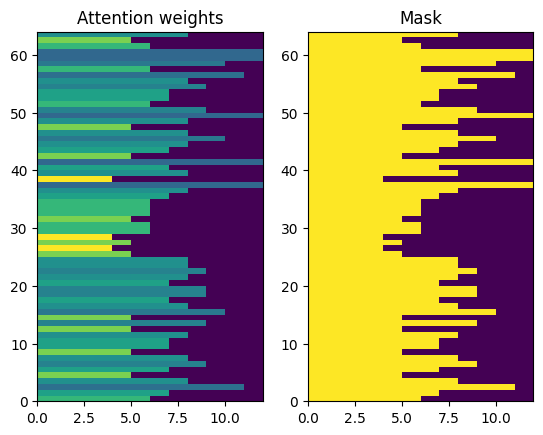

In [21]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [22]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)
  
  def call(self,
         context, x,
         state=None,
         return_state=False):  
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
      return logits, state
    else:
      return logits
  
  def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]
  
  def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result
  
  def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
      context, next_token,
      state = state,
      return_state=True) 

    if temperature == 0.0:
      next_token = tf.argmax(logits, axis=-1)
    else:
      logits = logits[:, -1, :]/temperature
      next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [23]:
decoder = Decoder(output_text_processor, UNITS)
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 12, 1024)
input target tokens shape: (batch, t) (64, 14)
logits shape shape: (batch, target_vocabulary_size) (64, 14, 5000)


In [24]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'londres restante otimos roubo venceu alergico street saudaveis estacao bilhete',
       b'conheco frequentemente azarado namorada delicioso chamalo telefonema ligo blusa adivinhar',
       b'sentia americano pegou feitos cachorro estranho muita facil colegas seja'],
      dtype=object)

In [25]:
class Translator(tf.keras.Model):
  def __init__(
      self,
      units,
      context_text_processor,
      target_text_processor
    ):
    super().__init__()
    # Build the encoder and decoder
    self.encoder = Encoder(context_text_processor, units)
    self.decoder = Decoder(target_text_processor, units)

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits
  
  def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
      # Generate the next token
      next_token, done, state = self.decoder.get_next_token(
          context, next_token, done,  state, temperature
      )
      # Collect the generated tokens
      tokens.append(next_token)
      attention_weights.append(self.decoder.last_attention_weights)
      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result
  
  def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.translate([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = preprocess_eng(text)
    context = context.numpy().decode().split()

    output = preprocess_pt(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

In [26]:
model = Translator(UNITS, input_text_processor, output_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 12)
Target tokens, shape: (batch, t) (64, 14)
logits, shape: (batch, t, target_vocabulary_size) (64, 14, 5000)


In [27]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [28]:
model.compile(
    optimizer='adam',
    loss=masked_loss,
    metrics=[masked_acc, masked_loss]
)

In [29]:
#The model is randomly initialized, and should give roughly uniform output probabilities.
#So it's easy to predict what the initial values of the metrics should be
vocab_size = 1.0 * input_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [30]:
#That should roughly match the values returned by running a few steps of evaluation:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 35ms/step - loss: 8.5230 - masked_acc: 2.9945e-04 - masked_loss: 8.5230


{'loss': 8.522966384887695,
 'masked_acc': 0.0002994496317114681,
 'masked_loss': 8.522966384887695}

In [31]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/100
100/100 [==============================] - 38s 173ms/step - loss: 3.9111 - masked_acc: 0.4007 - masked_loss: 3.9111 - val_loss: 3.0267 - val_masked_acc: 0.4891 - val_masked_loss: 3.0267
Epoch 2/100
100/100 [==============================] - 10s 104ms/step - loss: 2.7212 - masked_acc: 0.5256 - masked_loss: 2.7212 - val_loss: 2.3622 - val_masked_acc: 0.5696 - val_masked_loss: 2.3622
Epoch 3/100
100/100 [==============================] - 8s 76ms/step - loss: 2.1938 - masked_acc: 0.5938 - masked_loss: 2.1938 - val_loss: 2.0802 - val_masked_acc: 0.6016 - val_masked_loss: 2.0802
Epoch 4/100
100/100 [==============================] - 8s 84ms/step - loss: 1.9611 - masked_acc: 0.6238 - masked_loss: 1.9611 - val_loss: 1.8046 - val_masked_acc: 0.6476 - val_masked_loss: 1.8046
Epoch 5/100
100/100 [==============================] - 7s 74ms/step - loss: 1.8199 - masked_acc: 0.6446 - masked_loss: 1.8199 - val_loss: 1.5906 - val_masked_acc: 0.6674 - val_masked_loss: 1.5906
Epoch 6/100
100/

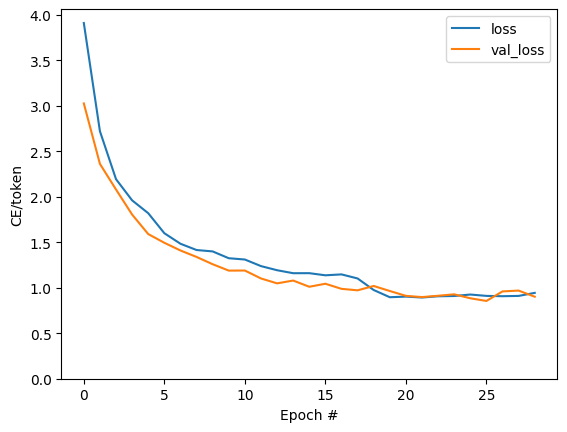

In [32]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

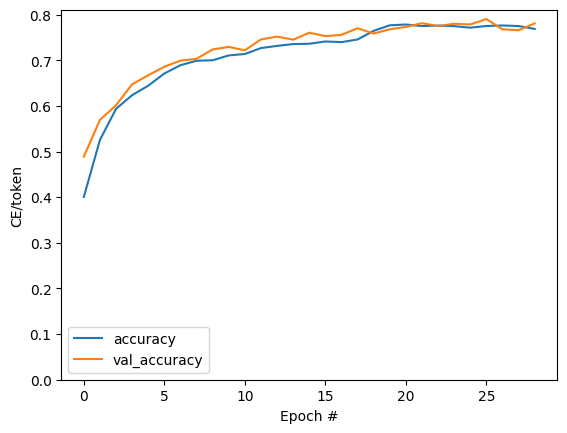

In [33]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [34]:
result = model.translate(["you don't deserve this."])
result[0].numpy().decode()

'voce nao merece isso . '

<ipython-input-25-b3ebfa11f517>:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-25-b3ebfa11f517>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


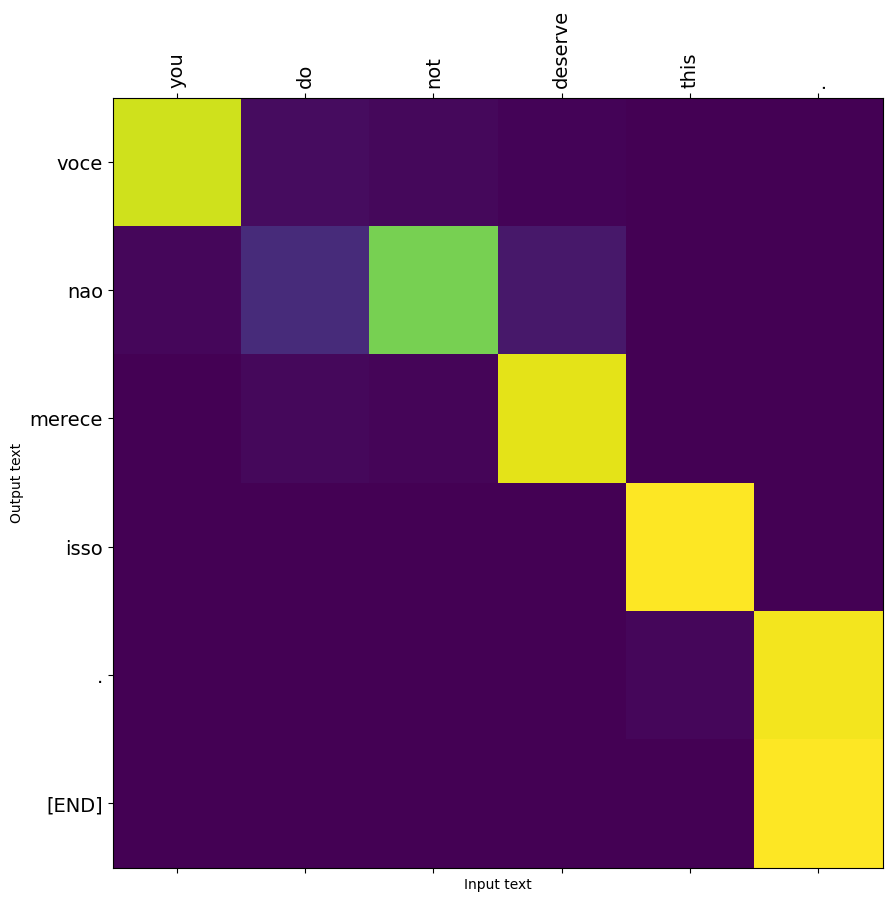

In [35]:
model.plot_attention("you don't deserve this.")

In [39]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from fuzzywuzzy import fuzz


test_inp = eng_data[is_test][:1600]
test_out = pt_data[is_test][:1600]
precisions = []
for i, text in enumerate(test_inp):
  result = model.translate([text])
  result = result[0].numpy().decode()

  valid = preprocess_pt(tf.Variable(test_out[i])).numpy().decode().replace('[START] ', '').replace(' [END]', '')
  precisions.append(fuzz.ratio(result, valid) / 100)
  #print('Correct: {} | Predicted: {}'.format(valid, result))
np.mean(precisions)

0.7542875000000001

In [36]:
model.save_weights('eng2pt.tf')